In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

# Parsing Helpers

In [3]:
def load_market_data(file, row_limit = None):
    md = pd.read_csv(file,sep=';')
    rename_columns = {'bid_price_1': 'bid', 'ask_price_1': 'ask', 'bid_volume_1': 'bid_sz', 'ask_volume_1': 'ask_sz'}
    md.rename(columns=rename_columns, inplace=True)
    if row_limit:
        markets = split_data_by_product(md.loc[md.timestamp <= row_limit])
    else:
        markets = split_data_by_product(md)
    symbols = list(markets.keys())
    print(f"Symbols: {symbols}")
    return markets

def split_data_by_product(df):
    markets = dict()
    df_grouped = df.groupby("product")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

In [4]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) ")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100 or t['timestamp'] == time:
                t['true_time'] = time-100 # Duplicates will be removed and first will be kept
                market_trades.append(t)

    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    market_trades.drop_duplicates(subset=['price', 'quantity', 'symbol', 'timestamp'], inplace=True)
    market_trades['timestamp'] = market_trades['true_time']
    market_trades.drop(columns=['true_time'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    df['side'] = df.apply(lambda x: np.sign(x['quantity']), axis=1)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum',
                                                                 'buy_vol':'sum','sell_vol':'sum','grey_vol':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'}).drop(columns=['notional'])
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    quote['volume'].fillna(0, inplace=True)
    for col in ['buy_vol', 'sell_vol','grey_vol', 'trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)
    # Active orders where remaining volume was left on the book
    fills['dup'] = False
    fills.loc[fills['active'], 'dup'] = fills.loc[fills['active']].duplicated(subset=['symbol','timestamp','price', 'side', 'active'])
    fills.loc[fills['dup'], 'active'] = False
    fills.drop(columns=['dup'], inplace=True)
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    for col in ['fill_qty','active_qty','passive_qty']:
        orders[col].fillna(0, inplace=True)
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders


def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    quote = combine_quote_trades(quote, market_trades.copy())
    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['quote'] = quote 
    dfs['order_depths'] = order_depths
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs


def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

# Experimental
def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

# Data Loading

In [5]:
file_name = "b63211d4-f94f-43ba-8d4c-33b245f1d78a"
file_name = "93591b9b-f688-41ad-89a4-af25561035f7" # acceptable price
file_name = "8fe34bcf-713b-4d7b-a87e-e4280b1465a8" # acceptable price, 1 less
# file_name = "18d4470e-3b22-4a32-867e-0e7bd7861cc6" # acceptable price, 2 less
# file_name = "5e3dec90-48ff-46f7-bb20-62579b414436"
# file_name = "db65aec5-7f9e-45e4-8054-879486bc9241" # Best run so far
file_name = "281ac96b-2019-4a66-8a0d-266a4ac59081" # Full run
# file_name = "ad3515ab-8af6-4d77-bdec-6c9e48b8ee5f"
# file_name = "baseline"

log_file = "logs/{}.log".format(file_name)
results_file = "logs/{}.csv".format(file_name)

dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [6]:
trades = dfs['market_trades']['PEARLS'].copy()
own_trades = dfs['own_trades']['PEARLS'].copy()

quote_md = dfs['order_depths']['PEARLS'].copy()

In [7]:
own_trades['quantity'].value_counts().cumsum()

1     266
2     354
5     384
4     413
3     435
8     455
10    471
6     483
9     495
7     505
Name: quantity, dtype: int64

# Intraday Plotting

In [8]:
fig_size = (6,3)

def plot_pnl(results):
    f, ax = plt.subplots(figsize=fig_size)
    for product in results:
        ax.plot("timestamp", "profit_and_loss", data=results[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel("PnL")
    ax.legend()
    ax.set_title("PnL")
    return

def plot_position(results):
    f, ax = plt.subplots(figsize=fig_size)
    for product in results:
        ax.plot("timestamp", "position", data=results[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.legend()
    ax.set_title("Position")
    return

def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return
    
def plot_cum_volume(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    data = md['volume'].cumsum()
    ax.plot(data, linestyle='-.')
    ax.set_xlabel("Time")
    ax.set_ylabel("Volume")
    ax.set_title(sym)
    return
    
def plot_spread(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "spread", data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel("Spread")
    ax.set_title(sym)
    return

def plot_price(md, sym, price_type):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", price_type, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_type.capitalize())
    ax.set_title(sym)
    return

def plot_ohcl(md, sym):
    # Candlestick plot
    pass

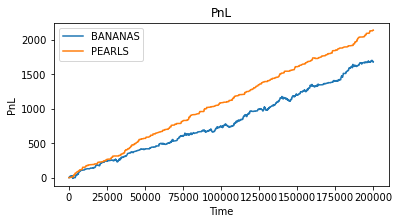

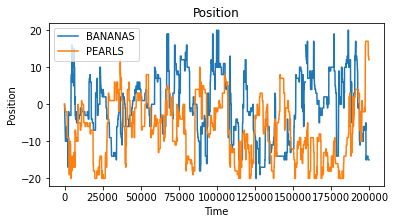

In [9]:
plot_pnl(results)
plot_position(dfs['positions'])

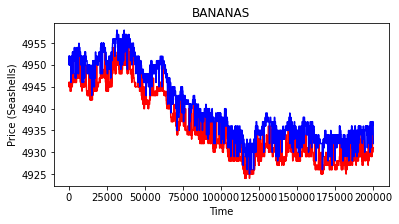

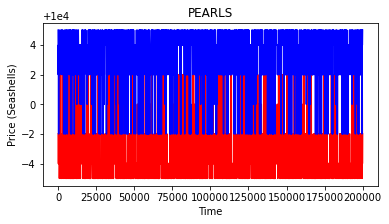

In [10]:
for s in symbols:
    plot_quote(dfs['quote'][s], s)
    # plot_price(markets[s], s, "mid_px_mavg10")

# Market Microstructure Analysis
- Spread Distribution
- Quote Size
- Notional
- Toxicity

In [11]:
def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def quote_squared_weighted_px_full(quote, levels=5):
    # Weighted average price, weight is the size of the quote squared
    notional = np.square(quote.bid_sz)*quote.bid + np.square(quote.ask_sz)*quote.ask
    size_squared = np.square(quote.bid_sz) + np.square(quote.ask_sz)
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*np.square(quote[f'bid_sz_{i}'])
        size_squared += np.square(quote[f'bid_sz_{i}'])
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*np.square(quote[f'ask_sz_{i}'])
        size_squared += np.square(quote[f'ask_sz_{i}'])
    
    return notional/size_squared

def md_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in [5, 10, 25, 50, 100]:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md.apply(quote_squared_weighted_px_full, axis=1)
    
    for t in [1, 5, 10, 20, 30, 50, 100]:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume    
    for t in [5, 10, 20, 30, 50]:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    md['vol_imb'] = (md.buy_vol/(md.buy_vol+md.sell_vol)).fillna(0.5)
    
    ############# Future
    # Future prices
    for t in [1, 5, 10, 20, 30, 50, 100]:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in [1, 5, 10, 20, 30, 50, 100]:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in [5, 10, 20, 30, 50]:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
    
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

def high_level_summary(sym, quote):
    print(sym)
    summary = quote.agg({
        'spread':['mean','std'], 
        'mid_price': 'std', 
        'px_move_1':'mean',
        'volume':'sum',
        'trades':'sum',
        'bid_sz': 'mean', 
        'ask_sz':'mean', 
        'bid_sz_2': 'mean',
        'ask_sz_2': 'mean',
    })
    display(summary)

In [12]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in [1, 5, 10, 20, 30, 50, 100]:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [13]:
hist_returns = []
log_returns = []
for t in [1, 5, 10, 20, 30, 50, 100]:
    hist_returns.append(f'px_move_{t}_norm')
    log_returns.append(f'log_return_{t}')
    
mavg_cols = []
for t in [5, 10, 25, 50, 100]:
    mavg_cols.append(f'mid_px_mavg{t}_norm')

## Bananas

In [14]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
quote = md_preprocess(quote)

BANANAS


In [15]:
high_level_summary(sym, quote)

BANANAS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,5.311156,NaN,-0.008754,NaN,NaN,17.550775,17.789895,23.063946,22.013928
std,1.895738,7.958557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,430.0,252.0,NaN,NaN,NaN,NaN


### Orderbook Analysis

In [16]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

,counts_bid,counts_ask
bid_levels,,
1,1264,1281
2,656,610
3,73,106
4,6,2


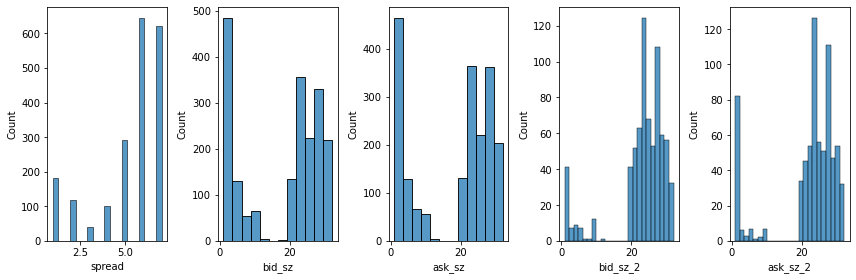

In [17]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['spread','bid_sz','ask_sz', 'bid_sz_2','ask_sz_2']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

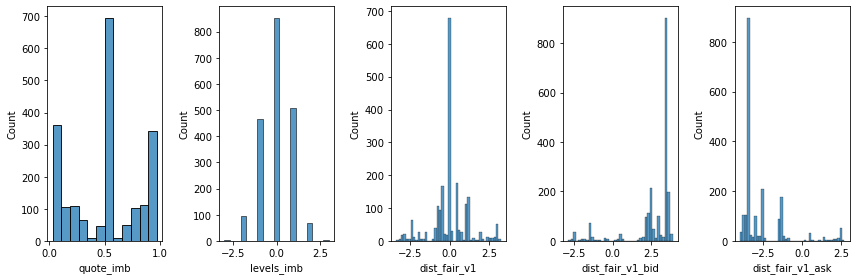

In [18]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['quote_imb','levels_imb', 'dist_fair_v1','dist_fair_v1_bid','dist_fair_v1_ask']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

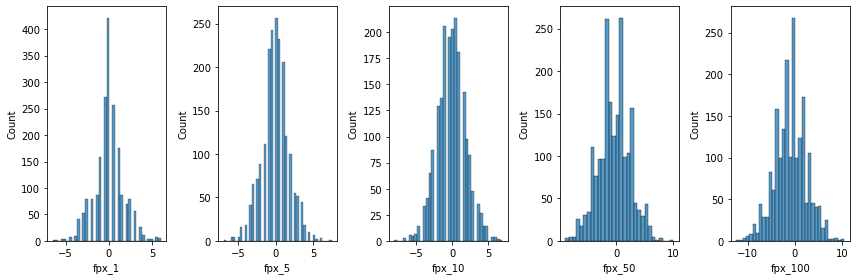

In [19]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['fpx_1','fpx_5','fpx_10','fpx_50','fpx_100']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [20]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'dist_fair_v2'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,quote_imb,levels_imb,dist_fair_v1,dist_fair_v2,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
quote_imb,1.000,-0.898,0.736,0.680,0.373,0.319,0.304,0.223,0.220,0.183,0.184
levels_imb,-0.898,1.000,-0.826,-0.765,-0.437,-0.370,-0.340,-0.272,-0.248,-0.214,-0.208
dist_fair_v1,0.736,-0.826,1.000,0.994,0.533,0.464,0.432,0.379,0.341,0.281,0.255
dist_fair_v2,0.680,-0.765,0.994,1.000,0.531,0.464,0.434,0.386,0.347,0.283,0.254
fpx_move_1,0.373,-0.437,0.533,0.531,1.000,0.384,0.313,0.273,0.251,0.203,0.167
fpx_move_5,0.319,-0.370,0.464,0.464,0.384,1.000,0.421,0.347,0.284,0.235,0.187
fpx_move_10,0.304,-0.340,0.432,0.434,0.313,0.421,1.000,0.431,0.387,0.311,0.252
fpx_move_20,0.223,-0.272,0.379,0.386,0.273,0.347,0.431,1.000,0.489,0.381,0.287
fpx_move_30,0.220,-0.248,0.341,0.347,0.251,0.284,0.387,0.489,1.000,0.520,0.346
fpx_move_50,0.183,-0.214,0.281,0.283,0.203,0.235,0.311,0.381,0.520,1.000,0.428


In [21]:
sub_data = quote.loc[np.abs(quote.volume) > 0].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'bid_improve','bid_revert','ask_improve','ask_revert'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 244 12.21%


,quote_imb,levels_imb,dist_fair_v1,bid_improve,bid_revert,ask_improve,ask_revert,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
quote_imb,1.000,-0.884,0.677,-0.247,0.144,0.360,-0.133,0.373,0.267,0.290,0.178,0.149,0.107,0.196
levels_imb,-0.884,1.000,-0.814,0.302,-0.166,-0.506,0.191,-0.452,-0.305,-0.331,-0.293,-0.217,-0.147,-0.210
dist_fair_v1,0.677,-0.814,1.000,-0.391,0.228,0.530,-0.258,0.550,0.444,0.421,0.395,0.359,0.220,0.205
bid_improve,-0.247,0.302,-0.391,1.000,-0.439,-0.142,0.224,-0.231,-0.084,-0.259,-0.178,-0.222,-0.163,-0.147
bid_revert,0.144,-0.166,0.228,-0.439,1.000,0.245,-0.257,0.241,0.053,0.055,0.103,0.173,0.115,0.177
ask_improve,0.360,-0.506,0.530,-0.142,0.245,1.000,-0.485,0.359,0.236,0.228,0.258,0.218,0.197,0.208
ask_revert,-0.133,0.191,-0.258,0.224,-0.257,-0.485,1.000,-0.179,-0.175,-0.152,-0.148,-0.154,-0.096,-0.042
fpx_move_1,0.373,-0.452,0.550,-0.231,0.241,0.359,-0.179,1.000,0.330,0.338,0.294,0.290,0.123,0.136
fpx_move_5,0.267,-0.305,0.444,-0.084,0.053,0.236,-0.175,0.330,1.000,0.462,0.330,0.251,0.241,0.229
fpx_move_10,0.290,-0.331,0.421,-0.259,0.055,0.228,-0.152,0.338,0.462,1.000,0.501,0.439,0.306,0.277


In [22]:
# Very little correlation between spread and past volume
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'fvolume', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,spread,fvolume,fvolume_5,fvolume_10,fvolume_20,fvolume_30,fvolume_50
spread,1.000,-0.100,-0.018,-0.025,-0.010,-0.010,0.020
fvolume,-0.100,1.000,0.436,0.321,0.233,0.196,0.159
fvolume_5,-0.018,0.436,1.000,0.706,0.516,0.442,0.347
fvolume_10,-0.025,0.321,0.706,1.000,0.721,0.616,0.480
fvolume_20,-0.010,0.233,0.516,0.721,1.000,0.840,0.666
fvolume_30,-0.010,0.196,0.442,0.616,0.840,1.000,0.807
fvolume_50,0.020,0.159,0.347,0.480,0.666,0.807,1.000


In [23]:
# Past price move vs future price move
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[log_returns + hist_returns + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,log_return_1,log_return_5,log_return_10,log_return_20,log_return_30,log_return_50,log_return_100,px_move_1_norm,px_move_5_norm,px_move_10_norm,px_move_20_norm,px_move_30_norm,px_move_50_norm,px_move_100_norm,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
log_return_1,1.000,0.447,0.315,0.223,0.181,0.140,0.097,0.015,0.008,0.007,0.007,0.008,0.008,0.009,-0.031,-0.028,-0.027,-0.026,0.021,0.023,0.002
log_return_5,0.447,1.000,0.706,0.498,0.406,0.313,0.218,0.004,0.008,0.006,0.007,0.008,0.010,0.015,0.009,-0.012,-0.043,0.033,0.055,0.047,0.031
log_return_10,0.315,0.706,1.000,0.705,0.575,0.443,0.309,-0.006,-0.003,0.008,0.008,0.010,0.013,0.020,-0.009,-0.031,-0.014,0.048,0.072,0.075,0.045
log_return_20,0.223,0.498,0.705,1.000,0.815,0.628,0.438,0.001,0.006,-0.005,0.011,0.013,0.017,0.027,-0.012,0.006,0.034,0.079,0.082,0.096,0.053
log_return_30,0.181,0.406,0.575,0.815,1.000,0.771,0.538,0.003,0.020,0.032,0.034,0.016,0.021,0.033,0.009,0.015,0.047,0.059,0.096,0.097,0.009
log_return_50,0.140,0.313,0.443,0.628,0.771,1.000,0.698,0.002,0.012,0.021,0.053,0.055,0.027,0.042,0.011,0.013,0.048,0.073,0.114,0.044,-0.044
log_return_100,0.097,0.218,0.309,0.438,0.538,0.698,1.000,0.001,0.002,0.007,0.017,0.031,0.058,0.060,0.009,0.009,0.034,0.031,0.023,-0.038,-0.062
px_move_1_norm,0.015,0.004,-0.006,0.001,0.003,0.002,0.001,1.000,0.496,0.434,0.379,0.354,0.304,0.253,-0.361,-0.320,-0.286,-0.275,-0.267,-0.229,-0.191
px_move_5_norm,0.008,0.008,-0.003,0.006,0.020,0.012,0.002,0.496,1.000,0.548,0.464,0.425,0.368,0.276,-0.322,-0.307,-0.280,-0.278,-0.241,-0.215,-0.182
px_move_10_norm,0.007,0.006,0.008,-0.005,0.032,0.021,0.007,0.434,0.548,1.000,0.558,0.501,0.430,0.335,-0.296,-0.291,-0.273,-0.250,-0.236,-0.230,-0.171


In [24]:
# Past price move vs future price move
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[mavg_cols + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,mid_px_mavg5_norm,mid_px_mavg10_norm,mid_px_mavg25_norm,mid_px_mavg50_norm,mid_px_mavg100_norm,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
mid_px_mavg5_norm,1.000,0.922,0.786,0.673,0.552,0.456,0.396,0.343,0.346,0.320,0.285,0.250
mid_px_mavg10_norm,0.922,1.000,0.896,0.774,0.636,0.444,0.399,0.358,0.352,0.326,0.295,0.247
mid_px_mavg25_norm,0.786,0.896,1.000,0.925,0.780,0.400,0.374,0.360,0.336,0.316,0.301,0.243
mid_px_mavg50_norm,0.673,0.774,0.925,1.000,0.913,0.348,0.322,0.325,0.301,0.279,0.283,0.238
mid_px_mavg100_norm,0.552,0.636,0.780,0.913,1.000,0.299,0.269,0.281,0.256,0.243,0.265,0.224
fpx_move_1,0.456,0.444,0.400,0.348,0.299,1.000,0.384,0.313,0.273,0.251,0.203,0.167
fpx_move_5,0.396,0.399,0.374,0.322,0.269,0.384,1.000,0.421,0.347,0.284,0.235,0.187
fpx_move_10,0.343,0.358,0.360,0.325,0.281,0.313,0.421,1.000,0.431,0.387,0.311,0.252
fpx_move_20,0.346,0.352,0.336,0.301,0.256,0.273,0.347,0.431,1.000,0.489,0.381,0.287
fpx_move_30,0.320,0.326,0.316,0.279,0.243,0.251,0.284,0.387,0.489,1.000,0.520,0.346


### Quote Change Analysis

In [28]:
quote_cols = ['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'bid_sz_2','ask_sz_2',
              'dist_fair_v1_bid','dist_fair_v1_ask', 'volume']

In [29]:
quote[quote_cols+px_delta_cols[:3]].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_v1_bid,dist_fair_v1_ask,volume,fpx_1,fpx_5,fpx_10
count,1999.00,1999.00,1999.00,1999.00,1999.00,735.00,718.00,1999.00,1999.00,1999.00,1999.00,1999.00,1999.00
mean,1.41,1.41,-0.00,17.55,17.79,23.06,22.01,2.67,-2.64,0.22,-0.01,-0.04,-0.08
std,0.58,0.60,0.92,11.30,11.19,7.45,8.74,1.50,1.49,0.89,1.68,1.83,2.00
min,1.00,1.00,-3.00,1.00,1.00,1.00,1.00,-2.89,-4.00,0.00,-6.50,-7.00,-8.00
25%,1.00,1.00,-1.00,4.00,4.00,22.00,21.00,2.45,-3.50,0.00,-1.00,-1.00,-1.50
50%,1.00,1.00,0.00,23.00,23.00,25.00,24.00,3.47,-3.46,0.00,0.00,0.00,0.00
75%,2.00,2.00,1.00,27.00,27.00,28.00,27.00,3.50,-2.52,0.00,1.00,1.00,1.00
max,4.00,4.00,3.00,32.00,32.00,32.00,32.00,3.89,2.72,14.00,6.00,7.50,7.00


In [30]:
quote.loc[quote.bid_improve][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_v1_bid,dist_fair_v1_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100
count,543.00,543.00,543.00,543.00,543.00,432.00,166.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00,543.00,543.0,543.00
mean,1.94,1.34,0.59,7.93,18.83,21.98,22.50,1.22,-2.99,0.23,-0.89,-0.94,-1.07,-1.10,-1.15,-1.3,-1.83
std,0.60,0.55,0.95,9.57,10.91,8.65,8.24,2.05,1.03,0.93,1.80,1.98,2.08,2.25,2.43,2.8,3.47
min,1.00,1.00,-2.00,1.00,1.00,1.00,1.00,-2.89,-4.00,0.00,-6.50,-7.00,-8.00,-7.50,-8.50,-8.5,-12.50
25%,2.00,1.00,0.00,1.00,5.50,21.00,22.00,-1.27,-3.53,0.00,-2.00,-2.50,-2.50,-2.50,-3.00,-3.0,-4.00
50%,2.00,1.00,1.00,3.00,23.00,24.00,24.00,2.22,-3.45,0.00,-0.50,-1.00,-1.00,-1.00,-1.00,-1.5,-2.00
75%,2.00,2.00,1.00,10.00,27.00,28.00,27.75,2.54,-2.62,0.00,0.00,0.50,0.50,0.50,0.50,0.5,0.50
max,4.00,3.00,3.00,32.00,32.00,32.00,31.00,3.70,2.46,14.00,5.50,6.00,6.00,6.00,5.50,6.5,7.00


In [31]:
quote.loc[quote.bid_revert][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_v1_bid,dist_fair_v1_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100
count,562.00,562.00,562.00,562.00,562.00,91.00,208.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,1.17,1.43,-0.26,22.09,17.61,24.67,22.01,3.27,-2.43,0.25,0.43,0.34,0.34,0.39,0.27,0.10,-0.28
std,0.39,0.60,0.76,8.79,11.23,5.14,8.35,0.64,1.76,0.90,1.57,1.81,1.86,2.22,2.35,2.75,3.26
min,1.00,1.00,-3.00,1.00,1.00,2.00,1.00,-1.47,-3.85,0.00,-3.50,-5.00,-5.00,-7.00,-6.00,-9.00,-10.00
25%,1.00,1.00,-1.00,21.00,4.00,22.00,21.00,3.45,-3.50,0.00,-0.50,-1.00,-1.00,-1.00,-1.50,-2.00,-2.50
50%,1.00,1.00,0.00,25.00,23.00,25.00,24.00,3.50,-3.50,0.00,0.00,0.50,0.00,0.50,0.50,0.00,-0.50
75%,1.00,2.00,0.00,28.00,27.00,28.00,27.00,3.50,-1.44,0.00,1.00,1.50,1.50,2.00,1.50,2.00,2.00
max,3.00,4.00,2.00,32.00,32.00,32.00,32.00,3.78,2.70,10.00,6.00,7.50,7.00,6.50,7.50,10.00,10.50


## Pearls

In [32]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
quote = md_preprocess(quote)

PEARLS


In [33]:
print(quote.columns)

Index(['timestamp', 'symbol', 'bid_levels', 'bid', 'bid_sz', 'bid_2',
       'bid_sz_2', 'bid_5', 'bid_sz_5', 'bid_4',
       ...
       'dist_fair_v1_bid', 'dist_fair_v1_ask', 'dist_fair_v2',
       'dist_fair_v2_norm', 'dist_fair_v2_bid', 'dist_fair_v2_ask',
       'bid_improve', 'bid_revert', 'ask_improve', 'ask_revert'],
      dtype='object', length=142)


In [34]:
high_level_summary(sym, quote)

PEARLS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,6.819410,NaN,0.0,NaN,NaN,8.352676,8.616308,19.81985,19.309966
std,2.467791,1.493635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,276.0,152.0,NaN,NaN,NaN,NaN


### Orderbook Analysis

In [ ]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['spread','bid_sz','ask_sz', 'bid_sz_2','ask_sz_2']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['quote_imb','levels_imb', 'dist_fair_full','dist_fair_bid','dist_fair_ask']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['fpx_1','fpx_5','fpx_10','fpx_50','fpx_100']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [ ]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

In [ ]:
sub_data = quote.loc[np.abs(quote.volume) > 2].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

In [ ]:
# Very little correlation between spread and past volume
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'fvolume', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

In [ ]:
# Past price move vs future price move
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[log_returns + hist_returns + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

### Quote Change Analysis
- What happens to the quote when price improves?
- What happens to the quote when a level is taken out?

In [ ]:
quote_cols = ['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'bid_sz_2','ask_sz_2',
              'dist_fair_bid','dist_fair_ask', 'volume']

In [ ]:
quote[quote_cols+px_delta_cols[:3]].describe().round(2)

In [ ]:
quote.loc[quote.bid_improve][quote_cols+px_delta_cols].describe().round(2)

In [ ]:
quote.loc[quote.bid_revert][quote_cols+px_delta_cols].describe().round(2)

## Pearls Price Cross Analysis
- What does the quote look like when bid/ask cross 10K?

In [ ]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

In [ ]:
bid_cross = quote.loc[quote.bid >= 10000].copy()
ask_cross = quote.loc[quote.ask <= 10000].copy()

In [ ]:
quote[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

In [ ]:
ask_cross[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

In [ ]:
bid_cross[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

# Regression

In [79]:
from sklearn.linear_model import LogisticRegression

In [80]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
quote = md_preprocess(quote)

BANANAS


In [95]:
features = ['dist_fair_v1', 'bid_sz', 'ask_sz', 'bid_improve', 'ask_improve', 'bid_revert','ask_revert']

labels = []
for t in [1, 5, 10, 20, 30, 50, 100]:
    labels.append(f'fpx_move_{t}')

In [ ]:
total_samples = len(quote)
train_samples = total_samples//2

train_data = quote.iloc[:train_samples][features+labels]
X_train = train_data[features].values
clfs = {}

for t in [1, 5, 10, 20, 30, 50, 100]:
    y_train = train_data[f'fpx_move_{t}'].values
    clfs[t] = LogisticRegression(random_state=0).fit(X_train, y_train)
    
for t in [1, 5, 10, 20, 30, 50, 100]:
    probs = clfs[t].predict_proba(X_train)
    train_data[f'predict_{t}'] = clfs[t].classes_[probs.argmax(axis=1)]
    train_data[f'predict_prob_{t}'] = probs.max(axis=1)
    train_data[f'correct_{t}'] = train_data[f'predict_{t}'] == train_data[f'fpx_move_{t}']
    print('{} {:.3}'.format(t, train_data[f'correct_{t}'].mean()))

In [ ]:
clfs[10].coef_

In [ ]:
temp = train_data.loc[train_data['predict_prob_50'] > 0.65]
print(temp['correct_50'].mean())
temp['correct_50'].value_counts()

In [ ]:
sns.displot(x='predict_prob_50',data=train_data, hue='correct',multiple='stack')

# Order and Position Analysis
- What is the fill rate of orders? Based on spread, levels in the book, recent price change, distance to bid/ask
- What is the holding time (assuming FIFO) of positions

In [207]:
toxicity_labels, reversion_labels = [], []
times = [1, 5, 10, 20, 30, 50, 100]
for t in times:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')
    
def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in [1, 5, 10, 20, 30, 50, 100]:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

In [229]:
file_name = "df46b7a9-0d68-4643-aefa-e0500a4b1ab1"
file_name = "93ee2859-ea97-4d9d-adb5-5e2f7d5be44f"
file_name = "a28dd216-1f1a-4d1f-a860-29a545d65c36"
file_name = "dd6f6c3e-be50-4fb8-a57c-44b3facf055c"
file_name = "e28115c2-c250-4719-99d9-e2186cd886f2"
file_name = "1580b658-1d57-4675-862d-f5ec3889c3d3"
file_name = "88f33525-04bf-4d19-82bc-34cd733d10da"
file_name = "f96bd42a-8693-4995-9142-350ca0330b28"
file_name = "14466b0e-7c27-4d1e-9e65-7eb21d9c259c" # Top of book+2
file_name = "783d222b-ad35-45df-a7f3-20110722bbc5"

file_name = "3042b6f6-309a-448a-810e-b3df69dbc68d"

log_file = "logs/{}.log".format(file_name)
results_file = "logs/{}.csv".format(file_name)

dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [237]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
market_trades = dfs['market_trades'][sym].copy()
fills = dfs['own_trades'][sym].copy()
positions = dfs['positions'][sym].copy()

orders = dfs['orders'][sym].copy()
orders = orders.loc[orders.quantity != 0].copy()
quote = md_preprocess(quote)
orders = orders.merge(quote, how='left',on=['symbol','timestamp'], suffixes=('','_q'))
orders = orders.merge(positions, how='left',on=['symbol','timestamp'], suffixes=('','_p'))

order_analysis(orders)

BANANAS


In [230]:
for sym in symbols:
    quote = dfs['order_depths'][sym].copy()
    market_trades = dfs['market_trades'][sym].copy()
    fills = dfs['own_trades'][sym].copy()
    positions = dfs['positions'][sym].copy()
    
    orders = dfs['orders'][sym].copy()
    orders = orders.loc[orders.quantity != 0].copy()
    quote = md_preprocess(quote)
    orders = orders.merge(quote, how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    orders = orders.merge(positions, how='left',on=['symbol','timestamp'], suffixes=('','_p'))
    
    order_analysis(orders)

    market_volume = market_trades['quantity'].sum()
    total_volume = orders.loc[orders.fill_qty > 0]['fill_qty'].sum()
    trade_count = len(orders.loc[orders.fill_qty > 0])
    pnl = results[sym]['profit_and_loss'].iloc[-1]
    print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | PnL/Share={:.4}""".format(sym, \
        pnl, trade_count, market_volume, total_volume,total_volume/market_volume, pnl/total_volume))

BANANAS: PnL=2213.34375 | Trades=518 | MarketVol=509 | Volume Filled=1606.0 | POV=3.2 | PnL/Share=1.378
PEARLS: PnL=2670.0 | Trades=570 | MarketVol=259 | Volume Filled=1792.0 | POV=6.9 | PnL/Share=1.49


In [74]:
for sym in symbols:
    display(dfs['positions'][sym].describe())

,timestamp,position
count,1996.000000,1995.000000
mean,100149.799098,6.187970
std,57634.337397,12.214821
min,-1.000000,-20.000000
25%,50275.000000,-2.000000
50%,100150.000000,9.000000
75%,150025.000000,17.000000
max,199900.000000,20.000000


,timestamp,position
count,1997.000000,1996.000000
mean,100099.849274,2.183367
std,57663.117722,9.967337
min,-1.000000,-20.000000
25%,50200.000000,-5.000000
50%,100100.000000,3.000000
75%,150000.000000,10.000000
max,199900.000000,20.000000


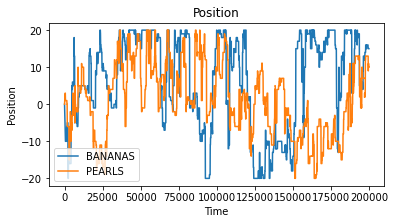

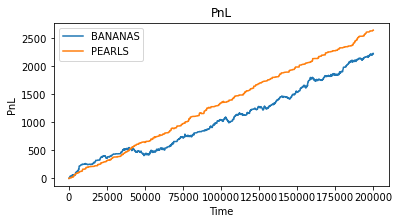

In [220]:
plot_position(dfs['positions'])
plot_pnl(results)

In [221]:
unfilled = orders.loc[orders.fill_qty == 0].copy()

In [238]:
fills = orders.loc[orders['fill_qty'] > 0].copy()
fills['active'] = fills.apply(lambda x: x['price'] >= x['ask'] if x['side'] == 1 else x['price'] <= x['bid'],axis=1)
fills['time_last'] = fills['timestamp'] - fills['timestamp'].shift(1)
fills['last_fill_sz'] = fills.groupby(['side'])['fill_qty'].shift(1)

In [244]:
fills.loc[fills.fill_qty >= 10][['price', 'quantity', 'symbol', 'timestamp', 'side','fill_qty', 'position','bid','ask','spread',
       'bid_sz', 'ask_sz', 'bid_levels', 'ask_levels', 'toxicity_10', 'toxicity_50', 'pnl_50', 'volume']]

,price,quantity,symbol,timestamp,side,fill_qty,position,bid,ask,spread,bid_sz,ask_sz,bid_levels,ask_levels,toxicity_10,toxicity_50,pnl_50,volume
145,4947,13.0,BANANAS,4200,1.0,12.0,-11.0,4946.0,4947.0,1.0,28.0,12.0,1.0,2.0,3.0,0.5,6.0,0.0
146,4947,9.0,BANANAS,4200,1.0,12.0,-11.0,4946.0,4947.0,1.0,28.0,12.0,1.0,2.0,3.0,0.5,6.0,0.0
214,4948,10.0,BANANAS,6200,1.0,10.0,10.0,4947.0,4948.0,1.0,30.0,13.0,1.0,2.0,2.5,1.0,10.0,0.0
223,4953,-20.0,BANANAS,6600,-1.0,18.0,20.0,4948.0,4955.0,7.0,27.0,27.0,1.0,1.0,3.5,5.5,99.0,0.0
539,4946,10.0,BANANAS,16000,1.0,10.0,10.0,4945.0,4950.0,5.0,27.0,7.0,1.0,3.0,1.5,2.5,25.0,0.0
576,4951,-10.0,BANANAS,17500,-1.0,10.0,16.0,4951.0,4953.0,2.0,11.0,24.0,2.0,1.0,2.5,-0.5,-5.0,0.0
1281,4954,-10.0,BANANAS,36700,-1.0,11.0,20.0,4954.0,4956.0,2.0,11.0,30.0,2.0,1.0,-2.0,3.5,38.5,1.0
1282,4954,-15.0,BANANAS,36700,-1.0,11.0,20.0,4954.0,4956.0,2.0,11.0,30.0,2.0,1.0,-2.0,3.5,38.5,1.0
2044,4949,-19.0,BANANAS,63000,-1.0,13.0,17.0,4943.0,4950.0,7.0,27.0,27.0,1.0,1.0,4.0,7.5,97.5,0.0
2183,4941,2.0,BANANAS,66500,1.0,11.0,-5.0,4940.0,4941.0,1.0,24.0,1.0,1.0,2.0,-0.5,-2.0,-22.0,0.0


In [223]:
fills.groupby(['side','fill_revert_50'])[['toxicity_50','toxicity_10']].agg(['mean','count', 'sum'])

toxicity_50              toxicity_10             
                           mean count    sum        mean count    sum
side fill_revert_50                                                  
-1   -1.0             -2.011364    44  -88.5    0.715909    44   31.5
      0.0              0.000000    12    0.0    0.916667    12   11.0
      1.0              3.077844   167  514.0    2.023952   167  338.0
 1   -1.0             -1.697531    81 -137.5    1.209877    81   98.0
      0.0              0.000000    15    0.0    1.333333    15   20.0
      1.0              2.594086   186  482.5    2.182796   186  406.0

In [224]:
fills.loc[fills.fill_revert_50 == -1][['price', 'quantity', 'symbol', 'timestamp', 'side','fill_qty', 'position','bid','ask',
       'bid_sz', 'ask_sz', 'bid_levels', 'ask_levels', 'toxicity_10', 'toxicity_50', 'pnl_50', 'volume']]

,price,quantity,symbol,timestamp,side,fill_qty,position,bid,ask,bid_sz,ask_sz,bid_levels,ask_levels,toxicity_10,toxicity_50,pnl_50,volume
32,4950,-14,BANANAS,1500,-1,1.0,-6.0,4950.0,4951.0,1.0,22.0,3.0,1.0,2.5,-0.5,-0.5,0.0
131,4949,-38,BANANAS,6300,-1,6.0,18.0,4947.0,4948.0,25.0,1.0,1.0,2.0,-0.5,-2.0,-12.0,0.0
140,4949,25,BANANAS,6800,1,2.0,-5.0,4948.0,4954.0,1.0,24.0,2.0,1.0,2.5,-1.5,-3.0,0.0
156,4947,24,BANANAS,7600,1,2.0,-4.0,4946.0,4953.0,26.0,26.0,1.0,1.0,0.5,-0.5,-1.0,0.0
182,4947,5,BANANAS,8800,1,4.0,-5.0,4945.0,4947.0,23.0,4.0,1.0,2.0,0.5,-0.5,-2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,4930,-11,BANANAS,179100,-1,11.0,-1.0,4930.0,4932.0,12.0,25.0,3.0,1.0,2.5,-0.5,-5.5,0.0
3423,4932,-23,BANANAS,180900,-1,2.0,3.0,4927.0,4933.0,1.0,29.0,2.0,1.0,3.0,-0.5,-1.0,0.0
3590,4931,-3,BANANAS,191300,-1,3.0,20.0,4931.0,4935.0,4.0,26.0,2.0,1.0,-2.5,-1.0,-3.0,0.0
3636,4933,-39,BANANAS,193600,-1,14.0,19.0,4928.0,4935.0,25.0,25.0,1.0,1.0,1.0,-1.0,-14.0,0.0


In [216]:
unfilled.loc[unfilled.px_bid_dist < 0][['price', 'quantity', 'symbol', 'timestamp', 'side','fill_qty', 'position','bid','ask',
       'bid_sz', 'ask_sz', 'fair_v1', 'toxicity_10', 'toxicity_50', 'pnl_50', 'volume', 'bid_2','ask_2', 'bid_sz_2','ask_sz_2']]

,price,quantity,symbol,timestamp,side,fill_qty,position,bid,ask,bid_sz,ask_sz,fair_v1,toxicity_10,toxicity_50,pnl_50,volume,bid_2,ask_2,bid_sz_2,ask_sz_2
31,4947,26,BANANAS,1500,1,0.0,-6.0,4950.0,4951.0,1,22,4947.600000,0.5,3.5,0.0,0.0,4945.0,NaN,2.0,NaN
56,4949,35,BANANAS,2800,1,0.0,-15.0,4952.0,4953.0,1,29,4949.343750,1.0,2.5,0.0,0.0,4947.0,NaN,5.0,NaN
98,4949,15,BANANAS,4800,1,0.0,5.0,4951.0,4952.0,1,1,4949.509804,4.5,-1.5,-0.0,0.0,4946.0,4953.0,25.0,24.0
119,4950,14,BANANAS,5800,1,0.0,6.0,4953.0,4954.0,1,24,4950.118644,1.0,0.0,0.0,0.0,4948.0,NaN,10.0,NaN
142,4950,23,BANANAS,6900,1,0.0,-3.0,4952.0,4954.0,1,28,4950.557377,-2.0,-2.5,-0.0,0.0,4951.0,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,4931,19,BANANAS,193900,1,0.0,1.0,4934.0,4935.0,1,31,4931.571429,1.5,1.0,0.0,0.0,4929.0,NaN,2.0,NaN
3712,4932,20,BANANAS,194000,1,0.0,0.0,4934.0,4935.0,1,28,4932.035088,0.5,0.0,0.0,0.0,4929.0,NaN,28.0,NaN
3769,4930,11,BANANAS,196700,1,0.0,9.0,4933.0,4934.0,1,23,4930.105263,-0.5,1.5,0.0,0.0,4928.0,NaN,10.0,NaN
3795,4932,8,BANANAS,197900,1,0.0,12.0,4935.0,4936.0,1,26,4932.809524,0.0,-0.5,-0.0,0.0,4934.0,NaN,10.0,NaN


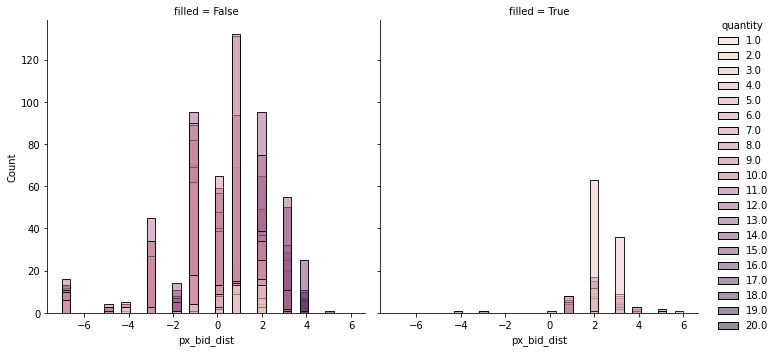

In [235]:
sns.displot(x='px_bid_dist', data=orders.loc[orders.side == 1], hue='quantity', col='filled')

## Fill Rate

In [ ]:
orders.groupby('side')[['fill_qty', 'quantity','active_qty','passive_qty']].agg(['sum','mean', 'count'])

In [ ]:
orders.loc[orders.fill_qty > 0].groupby('side')[['fill_qty', 'quantity']].describe()

In [ ]:
sns.displot(x='fill_qty',data=orders.loc[orders.side == 1], hue='px_bid_dist', height=3, multiple='stack')
sns.displot(x='fill_qty',data=orders.loc[orders.side == -1], hue='px_ask_dist', height=3, multiple='stack')

In [ ]:
sns.displot(x='fill_qty',data=orders, hue='spread', col='side', height=3, multiple='stack')
sns.displot(x='fill_qty',data=orders, hue='ask_levels', col='side', height=3, multiple='stack')
sns.displot(x='fill_qty',data=orders, hue='bid_levels', col='side', height=3, multiple='stack')

In [ ]:
orders.groupby(['side','bid_improve','bid_revert'])['fill_qty'].agg(['count','mean'])

In [ ]:
orders.groupby(['side', 'ask_improve','ask_revert'])['fill_qty'].agg(['count','mean'])